# 6 Hour Forecast using Static Graph

In [1]:
%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pickle # to access dataframe faster than csv
import glob, re
import os
import csv
from pathlib import Path
import scipy as sp
import networkx
import torch_geometric
import torch
from torch_geometric.utils.convert import from_networkx
from scipy.sparse import coo_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# for tweaked_TAGConv
import torch.nn as nn
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm # adjacency matrix normalization
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros # initialize weights and biases for nn
from torch_geometric.typing import Adj, OptTensor, SparseTensor
from torch_geometric.utils import spmm # for sparse matrix multiplication

# for normalizing
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
from utils import blocked_cross_validation_idx,get_windows_idx,get_train_batch_blocks

## Initialize
1. Aggregated (dataframe available at https://drive.google.com/drive/folders/1CwSLAJeCGUuHXRJOZ9YgkraHYaE8pGGH?usp=sharing)
2. Load aggregated
3. Load window csv with lclids corresponding to aggregated data

In [3]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

In [5]:
# load the data
file = open('uk-smart-meter-aggregated/df_agg.pkl','rb')
df_agg = pickle.load(file)
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2012-01-01 00:00:00 to 2013-12-31 23:00:00
Columns: 5558 entries, 2 to 5564
dtypes: float64(5558)
memory usage: 744.1 MB


In [6]:
file = open('uk-smart-meter-aggregated/windows_agg_ids.pkl','rb')
windows = pickle.load(file)
windows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5558 entries, 0 to 5557
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   LCLid        5558 non-null   int64          
 1   Enabled At   5558 non-null   datetime64[ns] 
 2   Disabled At  5558 non-null   datetime64[ns] 
 3   Duration     5558 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), timedelta64[ns](1)
memory usage: 217.1 KB


## Snapshot-based temporal graph
Idea: Build the adjacency matrix for all nodes using `create_adjacency_matrix`. Select a time-stamp for example [0]: '2012-01-01 00:00:00' or [1]: '2012-01-01 01:00:00' and so on. For this time-stamp what all nodes are active? Make an adjacency matrix for only these nodes for that particular time stamp using `get_snapshot_adjacency`. This function further returns the LCLids of active nodes (2,3,... 5564) and the indices of those active nodes (dataframe indices as in from range 0 to 5557).

1. Get the adjacency matrix for *all the nodes* at once to avoid computation

Number of unique start dates:  2154
Graph connected for k=50: True
sparsity:  0.9439180477754235


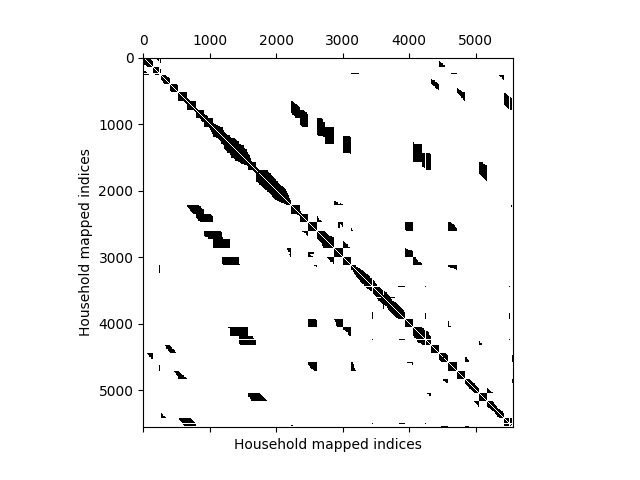

In [7]:
def create_adjacency_matrix(lclids, k):
    number_of_nodes = sum([len(l) for l in lclids])
    adjacency_matrix = np.zeros((number_of_nodes, number_of_nodes))
    # Create the graph by iterating over the list of lists of LCLids
    # and connecting all nodes in the list with each other
    # and with the k-nearest lists
    for i in range(len(lclids)): # range 2156
        for j in range(len(lclids)): # range 2156
            if i == j:
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
            elif abs(i-j) <= k:
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
    adjacency_matrix = adjacency_matrix - np.eye(number_of_nodes)
    return sp.sparse.bsr_array(adjacency_matrix)

# Sort rows by start date
windows_copy = windows.sort_values(by='Enabled At').copy()

# Get an ordered list of dates 'Enabled At'
enable_unique_dates = windows_copy['Enabled At'].unique()

# Get a list of lists of LCLids that have the same start date
nbor_lclids = [windows_copy[windows_copy['Enabled At'] == date].index.tolist() for date in enable_unique_dates]
print('Number of unique start dates: ', len(enable_unique_dates))
assert len(windows) == sum([len(l) for l in nbor_lclids])

# K-nearest neighbours
k = 50

adjacency_matrix = create_adjacency_matrix(nbor_lclids, k)
# Compute the sparsity of the adjacency matrix
sparsity = 1 - sp.sparse.bsr_matrix.count_nonzero(adjacency_matrix) / np.prod(adjacency_matrix.shape)
G = networkx.from_scipy_sparse_array(adjacency_matrix)
print(f'Graph connected for k={k}: {networkx.is_connected(G)}')
print('sparsity: ', sparsity)

plt.spy(sp.sparse.bsr_matrix.toarray(adjacency_matrix))
plt.xlabel("Household mapped indices"), plt.ylabel("Household mapped indices")
# save the adjacency matrix
np.save('Results/adjacency_matrix.npy', adjacency_matrix)
plt.show()

2. Make a function to get the sub-adjacency matrix for all nodes active at a given time instant

In [8]:
def get_snapshot_adjacency(timestampidx, full_adjacency_matrix, df_agg):
    """
    timestampidx: Time index; For example [0]: '2012-01-01 00:00:00'
    full_adjacency_matrix (np.array()): adjacency matrix for all the LCLids
    df_agg: aggregated dataframe with timeseries for all LCLids

    Returns:
    indices_active_nodes: dataframe indices of active nodes
    active nodes: LCLids of active nodes
    active_sparse_submat: adjacency matrix obtained for that particular timestamp (using timestampidx)
    """
    full_adjacency_matrix = full_adjacency_matrix.toarray()

    # get all the active nodes for that particular time-stamp
    active_nodes = df_agg.columns[df_agg.loc[df_agg.index[timestampidx], :].notna()]

    # indices of active nodes
    indices_active_nodes = windows[windows['LCLid'].isin(active_nodes.values)].index

    # active nodes sub-adjacency matrix
    active_adj_submat = full_adjacency_matrix[np.ix_(indices_active_nodes, indices_active_nodes)]

    if active_adj_submat.shape[0] != active_nodes.shape[0]:
        print(f'# active nodes = {active_nodes.shape}, while \
        Adjacency Matrix Shape = {active_adj_submat.shape}')
        raise RuntimeError()

    # create graph from the adjacency submatrix to check if it is connected
    active_sparse_submat = sp.sparse.bsr_array(active_adj_submat)

    ################ too slow ############################
    #G = networkx.from_scipy_sparse_array(active_sparse_submat)
    # check if the graph is fully connected
    # assert networkx.is_connected(G)

    # FOR FURTHER ANALYSIS
    #sparsity_submat = 1 - sp.sparse.bsr_matrix.count_nonzero(active_sparse_submat) \
    #/ np.prod(active_sparse_submat.shape)
    #print(f'Sparsity = {sparsity_submat}')


    # get edge indices from the adjacency submatrix COO Format
    # edge_index = torch.tensor(np.array(G.edges).T)
    #######################################################

    active_sparse_submat_coo = active_sparse_submat.tocoo()

    row = active_sparse_submat_coo.row
    col = active_sparse_submat_coo.col

    edge_index = torch.tensor(np.vstack((row, col)), dtype=torch.long)

    # node feature matrix
    node_feat = torch.tensor(df_agg.loc[df_agg.index[timestampidx],active_nodes].values).view(-1,1)
    return indices_active_nodes, active_nodes, active_sparse_submat, node_feat, edge_index


# example usage:
indices, activenodes, active_sparse_submat, node_feat, edge_idx = get_snapshot_adjacency(0, adjacency_matrix, df_agg) # check exact date using df_agg.index[100]

### Align snapshots

Idea: Take snapshots for a window and extract the sub-adjacency matrices (only considering active nodes) and node features. And stack these sub-adjacency matrices as a dictionary (book).

In [9]:
# print(f'Snapshots taken at {df_agg.index[0]}, {df_agg.index[50]}, {df_agg.index[100]} to calculate the supra adjacency matrix')
def get_subadj_book(window_idx, adjacency_matrix, df_agg):
    """
    Input:
        - window_idx:       window index (for eg., range(0,23) for first 24 hours)
        - adjacency_matrix: full adjacency matrix
        - df_agg:           aggregated dataframe
    Returns
        - idx_book:       dict of indices (of dataframe) of all active nodes throughout the window for all time instances
        - actnod_book:    dict of LCLids of active nodes throughout the window for all time instances
        - subadj_book:    dict of subadjacency matrices throughout the window for all time instances (can be of different sizes)
        - all_nodes:      set of LCLids of all active unique nodes inside the window_idx
        - node_feat_book: dict of node feature matrix throughout the window for all instances
        - edge_idx_book:  dict of edge index throughout the window for all instances
    """
    node_feat_book = {}
    edge_idx_book = {}
    subadj_book = {}
    idx_book = {}
    actnod_book = {}
    all_nodes = set()

    def process_idx(i, idx):
        idx_i, actnod_i, subadj_i, node_feat_i, edge_idx_i = get_snapshot_adjacency(idx, adjacency_matrix, df_agg)
        return i, idx_i, actnod_i, subadj_i, node_feat_i, edge_idx_i

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_idx, i, idx) for i, idx in enumerate(window_idx)]
        #print(futures)
        for future in as_completed(futures):
            i, idx_i, actnod_i, subadj_i, node_feat_i, edge_idx_i = future.result()
            idx_book[i] = idx_i
            actnod_book[i] = actnod_i
            subadj_book[i] = subadj_i.toarray()
            node_feat_book[i] = node_feat_i
            edge_idx_book[i] = edge_idx_i
            all_nodes.update(actnod_i)

    return idx_book, actnod_book, subadj_book, all_nodes, node_feat_book, edge_idx_book

window_idx = np.arange(128) #100*np.array([0,1,2,3,4,5,6,7,8,9,10]) # training window
idx_book, actnod_book, subadj_book, all_nodes, node_feat_book, edge_idx_book = get_subadj_book(window_idx, adjacency_matrix, df_agg)

Align the snapshots of different adjacency matrices to become size compatible. For example snapshot 1 has $R^{410\times410}$, snapshot 2 has $R^{450\times 450}$. This means that first snapshot has 410 active nodes and second snapshot has 450 active nodes. So, make a union set of all these nodes and "align" the shape of snapshot 2 adjacency matrix, node-features and edge_index to the shape of snapshot 2. So, snapshot 1 will also have adjacency matrix of size $R^{450\times 450}$ but with zeros at entries corresponding to the node that is not active in that snapshot 1.

In [10]:
def align_adjacency_matrix(active_nodes, subadj, all_nodes, node_index_map):
    """
    Input:
        - active_nodes: list of active nodes
        - subadj: sub-adjacency matrix for these active nodes
        - all_nodes: all the nodes for the entire window not just the instant where subadj and active_nodes are found
        - node_index_map: sorted all_nodes with {index: node...}


    """
    if not isinstance(subadj, np.ndarray):
        subadj = subadj.toarray()

    # Create a mapping from active node to index
    active_node_indices = [node_index_map[node] for node in active_nodes]

    # Create aligned subadjacency matrix
    aligned_subadj = np.zeros((len(all_nodes), len(all_nodes)))

    # Use numpy advanced indexing to place the subadj matrix in the correct positions
    aligned_subadj[np.ix_(active_node_indices, active_node_indices)] = subadj

    return aligned_subadj


def get_aligned_adj_book(subadj_book, node_feat_book, actnod_book, all_nodes):

    # create node index mapping
    # for ex., index_mapping = {0,1,2,3,4,5} for sorted nodes {1,2,3,4,5,6}
    node_index_map = {node: i for i, node in enumerate(sorted(all_nodes))} # node: idx dictionary

    # total nodes
    num_nodes = len(node_index_map)

    aligned_adj_book = {}
    aligned_node_feat_book = {}
    aligned_edge_index_book = {}

    for i, ((actkey, actnod), (subadjkey, subadj)) in enumerate(zip(actnod_book.items(), subadj_book.items())):

        aligned_adj_book[i] = align_adjacency_matrix(actnod, subadj, all_nodes, node_index_map)


        # Extract the indices of the non-zero elements (edges)
        row_indices, col_indices = np.nonzero(aligned_adj_book[i])

        # Combine the row and column indices to form the edge_index
        aligned_edge_index_book[i] = torch.tensor(np.vstack((row_indices, col_indices)))

        for j, key in enumerate(actnod.values):
            temp = np.zeros((len(all_nodes), 1))
            temp[node_index_map[key]] = node_feat_book[actkey][j]
        aligned_node_feat_book[i] = temp
    return aligned_adj_book, node_index_map, aligned_node_feat_book, aligned_edge_index_book



In [11]:
df = pd.DataFrame({
    'DateTime': pd.date_range(start='2012-01-01 00:00:00', end='2013-12-31 23:00:00', freq='1h')
})
train_months=2
test_months=1
batch_size=48
overlap_months=0
train_test_blocks=blocked_cross_validation_idx(df,train_months,test_months,overlap_months)[0]
batch_windows=get_train_batch_blocks(train_test_blocks[0],train_test_blocks[1],batch_size=batch_size)

In [12]:
len(batch_windows)

30

### Change dataset such that NaN becomes 0

In [18]:
df_agg.head()

,2,3,4,6,7,8,9,10,11,12,...,5535,5536,5537,5538,5541,5549,5550,5551,5557,5564
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Electricity consumption (kWh)')

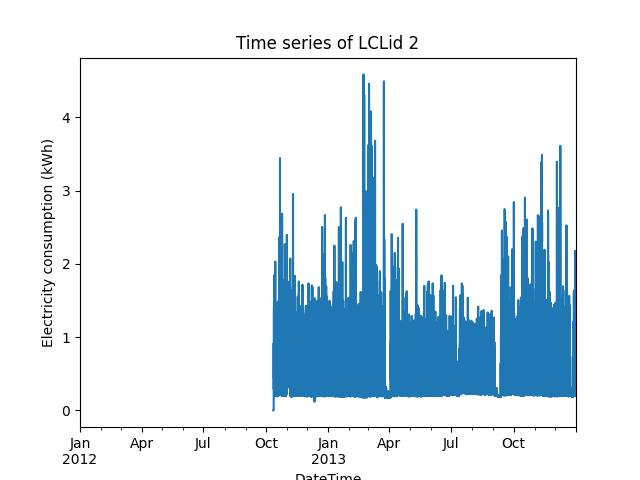

In [20]:
# Plot first Id over time
plt.figure()
df_agg.iloc[:,0].plot()
plt.title('Time series of LCLid 2')
plt.ylabel('Electricity consumption (kWh)')


In [24]:
# Check number of 0 values in df_agg
print(f"Number of 0 values in df: {(df_agg == 0.).sum(axis=1).sum(axis=0)}")
print(f"Number of NaN values in df: {df_agg.isna().sum().sum()}")

Number of 0 values in df: 649493
Number of NaN values in df: 0


## Set NaN number to -1

In [23]:
df_agg[df_agg.isna()] = -1.


In [25]:
df_normalised = df_agg.copy()
# Get the min and max of all rows
min = df_normalised.min(axis=1).min(axis=0)
max = df_normalised.max(axis=1).max(axis=0)
print("min: ", min, "max: ", max)
df_normalised = (df_normalised - min)/(max - min)

min:  -1.0 max:  20.8689995


In [26]:
window_idx=batch_windows[1]

df_agg
# extract the subadjacency matrix for all those time-stamps
idx_book, actnod_book, subadj_book, all_nodes, node_feat_book, edge_idx_book = get_subadj_book(window_idx, adjacency_matrix, df_agg)

aligned_adj_book, node_index_map, aligned_node_feat_book, aligned_edge_index_book = get_aligned_adj_book(subadj_book, node_feat_book, actnod_book, all_nodes)

### Graph-VAR for a static matrix

$$
\mathbf{x_t} = -\sum_{p=1}^{P} \sum_{k=0}^{K} h_{kp}\mathbf{S}^k \mathbf{x}_{t-p} 
$$

where P in our case will be 24. 

Dataset has 

In [14]:
batch_windows[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
      dtype=int64)

In [36]:
class TemporalGraphDataset:
    def __init__(self, adjacency_matrix, df_agg):
        self.graph_data = {}
        self.adjacency_matrix = adjacency_matrix
        self.df_agg = df_agg
        self.all_nodes_dict = {}

    def add_batch_instance(self, window_idx, b):
        # extract the subadjacency matrix for all those time-stamps
        idx_book, actnod_book, subadj_book, all_nodes, node_feat_book, edge_idx_book = get_subadj_book(window_idx, self.adjacency_matrix, self.df_agg)
        aligned_adj_book, node_index_map, aligned_node_feat_book, aligned_edge_index_book = get_aligned_adj_book(subadj_book, node_feat_book, actnod_book, all_nodes)

        if b not in self.all_nodes_dict:
            self.all_nodes_dict[b] = {}
        self.all_nodes_dict[b] = all_nodes

        # Initialize graph data for batch if not present
        if b not in self.graph_data:
            self.graph_data[b] = {}


        for i, idx in enumerate(window_idx):

            aligned_node_feat_book[i], aligned_edge_index_book[i], idx

            edge_index, edge_weight = gcn_norm(edge_index=aligned_edge_index_book[i].long(),
                                           edge_weight=None,
                                           num_nodes=aligned_node_feat_book[i].shape[0],
                                           add_self_loops=False)

            # Create a Data object with node features, edge index, and edge weights
            data = Data(x=torch.tensor(aligned_node_feat_book[i]).float(), edge_index=edge_index.float(), edge_weight = edge_weight)

            self.graph_data[b][idx] = data

    def get_batch_instance(self, b):
        return self.graph_data.get(b, "Batch not found.")

    def get_batch_time_instance(self, b, idx):
        return self.graph_data.get(b, {}).get(idx, "Time instance not found.")

    def get_all_nodes(self, b):
        return self.all_nodes_dict[b]

dataset = TemporalGraphDataset(adjacency_matrix, df_normalised)
for b, window_idx in enumerate(batch_windows):
    dataset.add_batch_instance(window_idx, b)

: 

In [ ]:
dataset.get_batch_instance(1)

{48: Data(x=[419, 1], edge_index=[2, 63454], edge_weight=[63454]),
 49: Data(x=[419, 1], edge_index=[2, 63454], edge_weight=[63454]),
 50: Data(x=[419, 1], edge_index=[2, 63454], edge_weight=[63454]),
 51: Data(x=[419, 1], edge_index=[2, 63454], edge_weight=[63454]),
 52: Data(x=[419, 1], edge_index=[2, 63454], edge_weight=[63454]),
 53: Data(x=[419, 1], edge_index=[2, 63454], edge_weight=[63454]),
 54: Data(x=[419, 1], edge_index=[2, 63454], edge_weight=[63454]),
 55: Data(x=[419, 1], edge_index=[2, 63454], edge_weight=[63454]),
 56: Data(x=[419, 1], edge_index=[2, 63454], edge_weight=[63454]),
 57: Data(x=[419, 1], edge_index=[2, 63976], edge_weight=[63976]),
 58: Data(x=[419, 1], edge_index=[2, 63804], edge_weight=[63804]),
 59: Data(x=[419, 1], edge_index=[2, 64314], edge_weight=[64314]),
 60: Data(x=[419, 1], edge_index=[2, 64482], edge_weight=[64482]),
 61: Data(x=[419, 1], edge_index=[2, 64646], edge_weight=[64646]),
 62: Data(x=[419, 1], edge_index=[2, 64646], edge_weight=[6464

In [ ]:
class TemporalGCNLayer(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, K: int, P: int): # P from window_idx = np.arange(P)
        super(TemporalGCNLayer, self).__init__(aggr = 'add') # 'Add' aggregation
        self.K = K
        self.P = P
        # self.normalize = normalize
        # self.linear = nn.Linear(in_channels, out_channels)
        self.h = nn.Parameter(torch.Tensor(K+1, P)) # depends on the order of filter and P
        self.reset_parameters() # initialize parameters
        self.m = nn.ReLU()

    def reset_parameters(self):
        #nn.init.xavier_uniform_(self.linear.weight) # initialize the weight of the linear layer
        #nn.init.zeros_(self.linear.bias)
        nn.init.xavier_uniform_(self.h)

    def forward(self, dataset, adj_sparse_tensor) -> Tensor:
        # keys of the given dataset as tensor
        indices = torch.Tensor(list(dataset.keys())).int()
        batch_size = len(indices) # 128
        first_idx = indices[0].item() # since it is a tensor

        # Intialize output tensor # (428, 104)
        out = torch.zeros(dataset[first_idx].x.shape[0], batch_size - self.P).to(device)

        # Cache adjacency matrices and feature matrices
        adj_sparse_tensor = adj_sparse_tensor.to(device)
        x_t_matrices = []

        for i in range(first_idx, first_idx + batch_size):
            x_t_matrices.append(dataset[i].x.to(device))

        # Compute the output using cached matrices
        for i_p in range(batch_size - self.P):
            out_kp = torch.zeros_like(x_t_matrices[0]).to(device)

            for p in range(self.P):
                idx = i_p + p
                x_t_minus_p = x_t_matrices[idx]

                for k in range(self.K + 1):
                    h_kp = self.h[k, p]
                    out_kp += h_kp * self.propagate(adj_sparse_tensor, x = x_t_minus_p, k = k)

            out[:, i_p] = out_kp.view(-1)

        return self.m(out)

    def propagate(self, adj_sparse_tensor, x = None, k = 1):
        x_out = x
        for _ in range(k):
            x_out = adj_sparse_tensor.matmul(x_out)
        return x_out

class TemporalGCN(nn.Module):
    def __init__(self, in_channels, out_channels, K, P):
        super(TemporalGCN, self).__init__()
        self.gcn_layer = TemporalGCNLayer(in_channels, out_channels, K, P)

    def forward(self, dataset, adj_sparse_tensor):
        return self.gcn_layer(dataset, adj_sparse_tensor)

# Initialize the model
in_channels = 1 # 1 feature
out_channels = 1 # 1 feature
K = 2 # order of polynomial filter
P = 12
model = TemporalGCN(in_channels, out_channels, K, P).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()

In [ ]:
from torch_geometric.utils import from_scipy_sparse_matrix
# Change scipy sparse matrix to pytorch geometric data
edge_index, edge_weight = from_scipy_sparse_matrix(adjacency_matrix)
edge_index, edge_weight = gcn_norm(edge_index=edge_index,
                                    num_nodes=df_normalised.shape[1],
                                    edge_weight=edge_weight,
                                    add_self_loops=False)
adj_matrix_sparse = SparseTensor(row = edge_index[0], col = edge_index[1], value = edge_weight)

In [ ]:
# count the number of parameters to verify
# for K = 2, P = 3, no. of parameters = 9
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(model)
print(f'The model has {num_params} parameters')

The model has 36 parameters


In [ ]:
def get_target(df, window_idx, all_nodes, P):
    target_timestamps = window_idx[P:]
    # get target values for all the nodes active for training
    targets = torch.Tensor([])
    for tt in target_timestamps:
        if targets.numel() == 0:  # Check if targets is empty
            targets = torch.tensor(df.loc[df.index[tt], list(all_nodes)].values).view(-1, 1).float()
        else:
            new_tensor = torch.tensor(df.loc[df.index[tt], list(all_nodes)].values).view(-1, 1).float()
            targets = torch.cat((targets, new_tensor), dim=1)
    targets = torch.nan_to_num(targets)
    return targets

In [ ]:
dataset.get_batch_instance(0)

NameError: name 'dataset' is not defined

In [ ]:
# Training Loop
num_epochs = 100

train_losses = []

predict=0
for epoch in tqdm(range(num_epochs)):
    batch_losses = []
    for i, batch in enumerate(batch_windows):

        model.train()
        optimizer.zero_grad()

        # Forward pass
        predict = model(dataset.get_batch_instance(i), adj_matrix_sparse)
        target = get_target(batch, dataset.get_all_nodes(i), P)

        loss = criterion(predict, target)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # train_losses.append(loss.item())
        # print(f'Batch loss: {loss.item():.4f}')
        batch_losses.append(loss.item())
    # if (epoch+1) % 20 == 0:
    train_losses.append(sum(batch_losses)/batch.shape[0])
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {sum(batch_losses)/batch.shape[0]:.4f}')
print("Training Finished!")

  1%|▉                                                                                              | 1/100 [00:22<36:43, 22.26s/it]

Epoch [1/100], Loss: 0.5538


  2%|█▉                                                                                             | 2/100 [00:50<41:52, 25.64s/it]

Epoch [2/100], Loss: 0.5506


  3%|██▊                                                                                            | 3/100 [01:20<45:02, 27.86s/it]

Epoch [3/100], Loss: 0.5473


  4%|███▊                                                                                           | 4/100 [01:53<47:50, 29.90s/it]

Epoch [4/100], Loss: 0.5443


  5%|████▊                                                                                          | 5/100 [02:25<48:05, 30.37s/it]

Epoch [5/100], Loss: 0.5414


  6%|█████▋                                                                                         | 6/100 [02:56<48:16, 30.81s/it]

Epoch [6/100], Loss: 0.5387


  7%|██████▋                                                                                        | 7/100 [03:32<50:13, 32.40s/it]

Epoch [7/100], Loss: 0.5361


  8%|███████▌                                                                                       | 8/100 [04:03<49:06, 32.03s/it]

Epoch [8/100], Loss: 0.5338


  9%|████████▌                                                                                      | 9/100 [04:34<48:03, 31.69s/it]

Epoch [9/100], Loss: 0.5316


 10%|█████████▍                                                                                    | 10/100 [05:05<47:10, 31.45s/it]

Epoch [10/100], Loss: 0.5296


 11%|██████████▎                                                                                   | 11/100 [05:36<46:33, 31.39s/it]

Epoch [11/100], Loss: 0.5277


 12%|███████████▎                                                                                  | 12/100 [06:09<46:38, 31.80s/it]

Epoch [12/100], Loss: 0.5260


 13%|████████████▏                                                                                 | 13/100 [06:39<45:34, 31.43s/it]

Epoch [13/100], Loss: 0.5245


 14%|█████████████▏                                                                                | 14/100 [07:10<44:45, 31.23s/it]

Epoch [14/100], Loss: 0.5230


 15%|██████████████                                                                                | 15/100 [07:42<44:18, 31.28s/it]

Epoch [15/100], Loss: 0.5218


 16%|███████████████                                                                               | 16/100 [08:19<46:09, 32.97s/it]

Epoch [16/100], Loss: 0.5206


 17%|███████████████▉                                                                              | 17/100 [09:02<49:56, 36.10s/it]

Epoch [17/100], Loss: 0.5196


 18%|████████████████▉                                                                             | 18/100 [09:47<52:49, 38.65s/it]

Epoch [18/100], Loss: 0.5186


 19%|█████████████████▊                                                                            | 19/100 [10:30<53:57, 39.96s/it]

Epoch [19/100], Loss: 0.5178


 20%|██████████████████▊                                                                           | 20/100 [11:14<55:05, 41.32s/it]

Epoch [20/100], Loss: 0.5170


 21%|███████████████████▋                                                                          | 21/100 [11:59<55:59, 42.53s/it]

Epoch [21/100], Loss: 0.5164


 22%|████████████████████▋                                                                         | 22/100 [12:44<56:07, 43.18s/it]

Epoch [22/100], Loss: 0.5158


 23%|█████████████████████▌                                                                        | 23/100 [13:28<55:39, 43.37s/it]

Epoch [23/100], Loss: 0.5153


 24%|██████████████████████▌                                                                       | 24/100 [14:13<55:26, 43.78s/it]

Epoch [24/100], Loss: 0.5148


 25%|███████████████████████▌                                                                      | 25/100 [14:55<54:08, 43.32s/it]

Epoch [25/100], Loss: 0.5144


 26%|████████████████████████▍                                                                     | 26/100 [15:41<54:27, 44.15s/it]

Epoch [26/100], Loss: 0.5141


 27%|█████████████████████████▍                                                                    | 27/100 [16:26<53:59, 44.38s/it]

Epoch [27/100], Loss: 0.5138


 28%|██████████████████████████▎                                                                   | 28/100 [17:11<53:35, 44.65s/it]

Epoch [28/100], Loss: 0.5135


 29%|███████████████████████████▎                                                                  | 29/100 [17:57<53:08, 44.90s/it]

Epoch [29/100], Loss: 0.5133


 30%|████████████████████████████▏                                                                 | 30/100 [18:42<52:31, 45.02s/it]

Epoch [30/100], Loss: 0.5130


 31%|█████████████████████████████▏                                                                | 31/100 [19:27<51:54, 45.14s/it]

Epoch [31/100], Loss: 0.5128


 32%|██████████████████████████████                                                                | 32/100 [20:10<50:14, 44.33s/it]

Epoch [32/100], Loss: 0.5127


 33%|███████████████████████████████                                                               | 33/100 [20:54<49:24, 44.25s/it]

Epoch [33/100], Loss: 0.5125


 34%|███████████████████████████████▉                                                              | 34/100 [21:38<48:29, 44.09s/it]

Epoch [34/100], Loss: 0.5124


 35%|████████████████████████████████▉                                                             | 35/100 [22:23<48:08, 44.44s/it]

Epoch [35/100], Loss: 0.5123


 36%|█████████████████████████████████▊                                                            | 36/100 [23:08<47:41, 44.71s/it]

Epoch [36/100], Loss: 0.5121


 37%|██████████████████████████████████▊                                                           | 37/100 [23:51<46:20, 44.13s/it]

Epoch [37/100], Loss: 0.5120


 38%|███████████████████████████████████▋                                                          | 38/100 [24:32<44:35, 43.15s/it]

Epoch [38/100], Loss: 0.5119


 39%|████████████████████████████████████▋                                                         | 39/100 [25:14<43:37, 42.91s/it]

Epoch [39/100], Loss: 0.5118


 40%|█████████████████████████████████████▌                                                        | 40/100 [26:38<55:16, 55.27s/it]

Epoch [40/100], Loss: 0.5118


 41%|██████████████████████████████████████▌                                                       | 41/100 [27:08<46:41, 47.49s/it]

Epoch [41/100], Loss: 0.5117


 42%|███████████████████████████████████████▍                                                      | 42/100 [27:39<41:13, 42.65s/it]

Epoch [42/100], Loss: 0.5116


 43%|████████████████████████████████████████▍                                                     | 43/100 [28:10<37:12, 39.17s/it]

Epoch [43/100], Loss: 0.5115


 44%|█████████████████████████████████████████▎                                                    | 44/100 [28:41<34:20, 36.80s/it]

Epoch [44/100], Loss: 0.5115


 45%|██████████████████████████████████████████▎                                                   | 45/100 [29:12<32:09, 35.09s/it]

Epoch [45/100], Loss: 0.5114


 46%|███████████████████████████████████████████▏                                                  | 46/100 [29:44<30:41, 34.11s/it]

Epoch [46/100], Loss: 0.5114


 47%|████████████████████████████████████████████▏                                                 | 47/100 [30:17<29:43, 33.65s/it]

Epoch [47/100], Loss: 0.5113


 48%|█████████████████████████████████████████████                                                 | 48/100 [30:50<29:08, 33.62s/it]

Epoch [48/100], Loss: 0.5113


 49%|██████████████████████████████████████████████                                                | 49/100 [31:23<28:23, 33.40s/it]

Epoch [49/100], Loss: 0.5112


 50%|███████████████████████████████████████████████                                               | 50/100 [31:57<27:48, 33.38s/it]

Epoch [50/100], Loss: 0.5112


 51%|███████████████████████████████████████████████▉                                              | 51/100 [32:31<27:29, 33.67s/it]

Epoch [51/100], Loss: 0.5111


 52%|████████████████████████████████████████████████▉                                             | 52/100 [33:04<26:48, 33.50s/it]

Epoch [52/100], Loss: 0.5111


 53%|█████████████████████████████████████████████████▊                                            | 53/100 [33:37<26:08, 33.38s/it]

Epoch [53/100], Loss: 0.5110


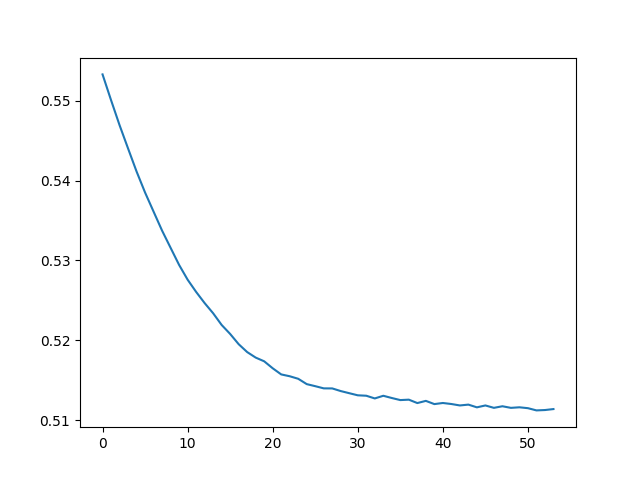

In [19]:
fig, ax = plt.subplots()
ax.plot(train_losses)

In [20]:
# saving trained model
torch.save(model.state_dict(), 'model_parameters.pth')

In [ ]:
# # Instantiate the model first
# model = SimpleModel()

# # Load the model parameters
# model.load_state_dict(torch.load('model_parameters.pth'))
# model.eval()  # Set the model to evaluation mode if you are using it for inference

## Below part is not useful but kept for backup.

### Build the supra-adjacency matrix $S_\diamond$ from all the aligned subadjacency matrices "book" $\$_i$ 
Build a supra-adjacency matrix for $n$ time instances using spatio-temporal coupling. Note: we cannot use the kronecker product here since at all instances, the adjacnecy matrix `aligned_subadj1/2/3` is different. 

In [ ]:
def supra_adjacency_matrix(aligned_subadj_book):

    # convert the dict to stack
    stacked_aligned_subadj = np.stack(list(aligned_book.values()), axis = -1)

    # time instances
    instances = stacked_aligned_subadj.shape[2]

    # size of aligned
    a_size = stacked_aligned_subadj.shape[0]

    # supra
    S = np.zeros((a_size*instances, a_size*instances))

    # Place aligned at appropriate locations for spatio-temporal coupling
    # temporal + own-node spatial component
    for i in range(1,instances):
        S[i*a_size:(i+1)*a_size, (i-1)*a_size:i*a_size] = stacked_aligned_subadj[...,i-1] + np.eye(a_size) # last term is own-node spatial component
    # spatial coupling
    for i in range(instances):
        S[i*a_size:(i+1)*a_size, i*a_size:(i+1)*a_size] = stacked_aligned_subadj[...,i]

    return S

supra_adj_mat = supra_adjacency_matrix(aligned_book)

In [ ]:
fig, ax = plt.subplots()
plt.spy(supra_adj_mat)
plt.show()

### Imputation on Supra-adjacency matrix/Product Graph

In [ ]:
len(all_nodes)*len(window_idx)

In [ ]:
# fill the y_diamond using data
y_diamond = np.zeros([len(all_nodes)*len(actnod_book), 1])

# the index with corresponding lclid will get the data

# 6th LCLid
y_diamond[0] = df_agg.loc[df_agg.index[window_idx[0]],list(all_nodes)[0]]
# 16th LCLid
y_diamond[1] = df_agg.loc[df_agg.index[window_idx[1]], list(all_nodes)[1]]
